# Elementary analysis of numerical data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 
import scipy.linalg as linalg
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.interpolate as interpolate

In [3]:
np.set_printoptions(precision=3)

This just gets rid of a known harmless warning message when an old version o lapack is used.

In [4]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [5]:
warnings.simplefilter('ignore', RuntimeWarning)

## Linear algebra

### Matrix multiplication

In [6]:
x = np.random.random((2,3))
y = np.random.random((3,2))

In [7]:
x @ y

array([[ 0.451,  1.415],
       [ 0.442,  1.661]])

In [8]:
x.dot(y)

array([[ 0.451,  1.415],
       [ 0.442,  1.661]])

In [9]:
np.dot(x, y)

array([[ 0.451,  1.415],
       [ 0.442,  1.661]])

### Solving linear equations

\begin{align}
3x + 2y + z &= 17 \\
x + 4y + 3z &= 23 \\
2x + y + 5z &= 22
\end{align}

In [10]:
A = np.array([[3,2,1],[1,4,3],[2,1,5]])
b = np.array([17,23,22])

In [11]:
sol = linalg.solve(A, b)

In [12]:
sol

array([ 2.739,  3.043,  2.696])

#### Check

In [13]:
A @ sol

array([ 17.,  23.,  22.])

#### Using the inverse

This is numerically less efficient and stable than using `solve`. Don't do this.

In [14]:
linalg.inv(A) @ b

array([ 2.739,  3.043,  2.696])

### Many solution sets

In [15]:
b1 = np.random.random(3)
b2 = np.random.random(3)

#### Using solve repeatedly is wasteful

In [16]:
linalg.solve(A, b1)

array([-0.097,  0.205,  0.049])

In [17]:
linalg.solve(A, b2)

array([ 0.026,  0.205,  0.05 ])

#### Do LU decomposition once and reuse

In [18]:
lu_piv = linalg.lu_factor(A)

In [19]:
for b in [b1, b2]:
    print(linalg.lu_solve(lu_piv, b))

[-0.097  0.205  0.049]
[ 0.026  0.205  0.05 ]


### Solving linear least squares

In many situations, there are more observations than variables. In this case, we use linear least squares to find the best linear approximation to the solution - i.e. $Ax' \sim b$ in the sense that $Ax'$ is a vector in the column space of $A$ that has the smallest squared Euclidean distance to $b$.

In [20]:
A = np.random.random((10, 3))
b = np.random.random(10)

In [21]:
try:
    linalg.solve(A, b)
except ValueError as e:
    print(e)

Input a needs to be a square matrix.


#### Normal equations

In your statistics classes, you will learn about why the "normal" equations $(A^TA)^{-1}A^Tb$ gives the least squares solution.

In [22]:
linalg.inv(A.T@A) @ A.T @ b

array([ 0.693,  0.226,  0.268])

#### Using lstsq

This provide an optimized method for solving the least squares problem. 

In [23]:
x, *_ = linalg.lstsq(A, b)

In [24]:
x

array([ 0.693,  0.226,  0.268])

In [25]:
linalg.eigh(np.array([[1,2],[2,4]]))

(array([ 0.,  5.]), array([[-0.894,  0.447],
        [ 0.447,  0.894]]))

### Finding eigenvectors and eigenvalues

#### Use `eigh` for complex Hermitian or real symmetric matrix 

In [26]:
A = np.diag([1,2,3,4])
A

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

In [27]:
l, v = linalg.eigh(A)

In [28]:
l

array([ 1.,  2.,  3.,  4.])

In [29]:
v

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

#### Use `eig` if not complex Hermitian or real symmetric matrix

In [30]:
A = np.random.random((4,4))

In [31]:
l, v = linalg.eig(A)

In [32]:
l

array([ 2.155+0.j   , -0.165+0.j   , -0.446+0.078j, -0.446-0.078j])

In [33]:
v

array([[ 0.579+0.j   , -0.436+0.j   , -0.600-0.149j, -0.600+0.149j],
       [ 0.592+0.j   , -0.490+0.j   , -0.017-0.068j, -0.017+0.068j],
       [ 0.341+0.j   ,  0.184+0.j   , -0.048+0.21j , -0.048-0.21j ],
       [ 0.445+0.j   ,  0.732+0.j   ,  0.753+0.j   ,  0.753-0.j   ]])

### Diagonalizable matrices

In [34]:
A = np.array([
    [0.,0,-2],
    [1,2,1],
    [1,0,3]
])

In [35]:
A

array([[ 0.,  0., -2.],
       [ 1.,  2.,  1.],
       [ 1.,  0.,  3.]])

In [36]:
lam, Q = linalg.eig(A)

In [37]:
lam = np.real_if_close(lam)
lam

array([ 2.,  1.,  2.])

A diagonalizable matrix has linearly $n$ linearly independent eigenvectors.

In [38]:
np.linalg.matrix_rank(Q)

3

For a diagonalizable matrix, you can recover A as the product of $Q D Q^{-1}$ where $Q$ is the matrix of eigenvectors and $D$ is the diagonal matrix from the eigenvalues.

In [39]:
Q @ np.diag(lam) @ linalg.inv(Q) 

array([[ 0.,  0., -2.],
       [ 1.,  2.,  1.],
       [ 1.,  0.,  3.]])

#### Finding powers of a diagonalizable matrix

In [40]:
from functools import reduce

In [41]:
reduce(lambda x, y: x @ y, [A]*10)

array([[-1022.,     0., -2046.],
       [ 1023.,  1024.,  1023.],
       [ 1023.,     0.,  2047.]])

In [42]:
Q @ np.diag(lam**10) @ linalg.inv(Q)

array([[-1022.,     0., -2046.],
       [ 1023.,  1024.,  1023.],
       [ 1023.,     0.,  2047.]])

### Singular value decomposition

Generalization of eigendecomposition to non-square matrices.

In [43]:
A = np.random.random((6,10))

In [44]:
U, s, V = linalg.svd(A, full_matrices=False)

In [45]:
U.shape

(6, 6)

In [46]:
s.shape

(6,)

In [47]:
V.shape

(6, 10)

#### Reconstructing A from SVD

In [48]:
A

array([[ 0.053,  0.892,  0.786,  0.519,  0.503,  0.885,  0.96 ,  0.828,
         0.084,  0.914],
       [ 0.25 ,  0.747,  0.711,  0.222,  0.585,  0.876,  0.691,  0.407,
         0.883,  0.113],
       [ 0.051,  0.075,  0.046,  0.701,  0.952,  0.112,  0.791,  0.714,
         0.448,  0.455],
       [ 0.618,  0.273,  0.083,  0.883,  0.909,  0.236,  0.178,  0.21 ,
         0.453,  0.504],
       [ 0.613,  0.367,  0.515,  0.731,  0.538,  0.248,  0.19 ,  0.729,
         0.214,  0.134],
       [ 0.181,  0.409,  0.974,  0.354,  0.806,  0.9  ,  0.009,  0.464,
         0.986,  0.948]])

In [49]:
U @ np.diag(s) @ V

array([[ 0.053,  0.892,  0.786,  0.519,  0.503,  0.885,  0.96 ,  0.828,
         0.084,  0.914],
       [ 0.25 ,  0.747,  0.711,  0.222,  0.585,  0.876,  0.691,  0.407,
         0.883,  0.113],
       [ 0.051,  0.075,  0.046,  0.701,  0.952,  0.112,  0.791,  0.714,
         0.448,  0.455],
       [ 0.618,  0.273,  0.083,  0.883,  0.909,  0.236,  0.178,  0.21 ,
         0.453,  0.504],
       [ 0.613,  0.367,  0.515,  0.731,  0.538,  0.248,  0.19 ,  0.729,
         0.214,  0.134],
       [ 0.181,  0.409,  0.974,  0.354,  0.806,  0.9  ,  0.009,  0.464,
         0.986,  0.948]])

#### Condition number is ratio of largest to smallest singular value

Very large numbers suggest that matrix multiplications will be numerically unstable.

In [50]:
s[0]/s[-1]

8.6144185014856678

#### SVD is often used for dimension reduction

We construct a $10 \times 6$ matrix with only 3 independent coluumns

In [51]:
x = np.random.random((10,3))
A = np.c_[x, x]

In [52]:
U, s, V = linalg.svd(A)

In [53]:
U.shape, s.shape, V.shape

((10, 10), (6,), (6, 6))

In [54]:
s[0]/s[-1]

80843248563455600.0

In [55]:
k = len(s > 1e-10)

In [56]:
k

6

#### Dimension reduction

We only need $k$ columns from $U$ and $k$ rows from $V$ to reproduce $A$.

In [57]:
U[:, :k] @ np.diag(s[:k]) @ V[:k, :]

array([[ 0.66 ,  0.191,  0.324,  0.66 ,  0.191,  0.324],
       [ 0.674,  0.24 ,  0.602,  0.674,  0.24 ,  0.602],
       [ 0.704,  0.813,  0.927,  0.704,  0.813,  0.927],
       [ 0.527,  0.873,  0.387,  0.527,  0.873,  0.387],
       [ 0.42 ,  0.427,  0.161,  0.42 ,  0.427,  0.161],
       [ 0.737,  0.245,  0.99 ,  0.737,  0.245,  0.99 ],
       [ 0.4  ,  0.004,  0.13 ,  0.4  ,  0.004,  0.13 ],
       [ 0.614,  0.183,  0.999,  0.614,  0.183,  0.999],
       [ 0.166,  0.835,  0.591,  0.166,  0.835,  0.591],
       [ 0.171,  0.215,  0.501,  0.171,  0.215,  0.501]])

In [58]:
A

array([[ 0.66 ,  0.191,  0.324,  0.66 ,  0.191,  0.324],
       [ 0.674,  0.24 ,  0.602,  0.674,  0.24 ,  0.602],
       [ 0.704,  0.813,  0.927,  0.704,  0.813,  0.927],
       [ 0.527,  0.873,  0.387,  0.527,  0.873,  0.387],
       [ 0.42 ,  0.427,  0.161,  0.42 ,  0.427,  0.161],
       [ 0.737,  0.245,  0.99 ,  0.737,  0.245,  0.99 ],
       [ 0.4  ,  0.004,  0.13 ,  0.4  ,  0.004,  0.13 ],
       [ 0.614,  0.183,  0.999,  0.614,  0.183,  0.999],
       [ 0.166,  0.835,  0.591,  0.166,  0.835,  0.591],
       [ 0.171,  0.215,  0.501,  0.171,  0.215,  0.501]])

### Matrix norms

In [59]:
A = np.array([[1,2],[3,4]])
A

array([[1, 2],
       [3, 4]])

#### Frobenius norm

In [60]:
linalg.norm(A)

5.4772255750516612

In [61]:
np.sqrt((A**2).sum())

5.4772255750516612

#### Largest singular value

In [62]:
linalg.norm(A, 2)

5.4649857042190426

In [63]:
linalg.svd(A)[1][0]

5.4649857042190426

#### Largest row sum

In [64]:
linalg.norm(A, np.inf)

7.0

In [65]:
A.sum(1).max()

7

#### Largest column sum

In [66]:
linalg.norm(A, 1)

6.0

In [67]:
A.sum(0).max()

6

## Integration

It is common to need to find areas under curves in statistics, for example, to estimate the probability mass under a distribution for a certain range of values.

In [68]:
d = stats.norm(0, 1)

In [69]:
integrate.quad(d.pdf, -1, 1)

(0.682689492137086, 7.579375928402476e-15)

#### What is the area between the curve and the x-axis?

In [70]:
def f(x):
    return 1 + x * np.cos(71*x) + np.sin(13*x)

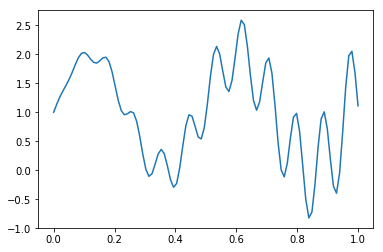

In [71]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

In [72]:
integrate.quad(f, 0, 1)

(1.020254939102394, 1.636375780468161e-14)

#### Romber, trapezoidal and Simpson's methods are mainly for pedagogical reasons

In [73]:
integrate.romberg(f, 0, 1)

1.0202549391050357

In [74]:
integrate.trapz(f(x), x)

1.0196541685543563

In [75]:
integrate.simps(f(x), x)

1.0202546407742057

#### Integration in higher dimensions

In [76]:
d = stats.multivariate_normal(np.zeros(2), np.eye(2))

In [77]:
integrate.nquad(lambda x, y: d.pdf([x, y]), [[-2,2], [-2,2]])

(0.9110697462219217, 1.7566204076527952e-11)

### Integrating ODEs

In [78]:
def f(x, t, a, b, c, d):
    """Lotka-Volterra model."""
    u, v = x
    return [a*u + b*u*v, c*v + d*u*v]

In [79]:
a, b, c, d = 1, -1, -1, .5
x0 = [0.5,0.5]
t = np.linspace(0, 22, 100)

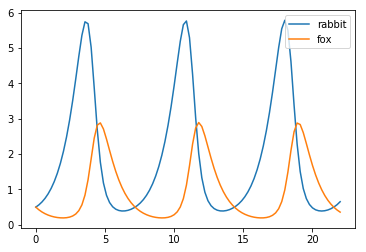

In [80]:
y = integrate.odeint(f, x0, t, args=(a,b,c,d))
plt.plot(t, y)
plt.legend(['rabbit','fox'], loc='best')
pass

## Optimization

### Scalar valued function

In [81]:
def f(x):
    return 3 + 4*x + 2*x**2

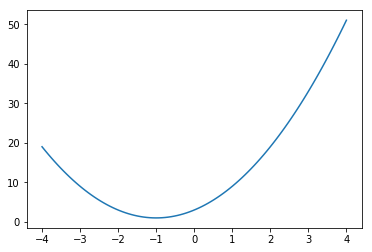

In [82]:
x = np.linspace(-4, 4, 100)
plt.plot(x, f(x))
pass

In [83]:
optimize.minimize_scalar(f)

     fun: 1.0
    nfev: 5
     nit: 4
 success: True
       x: -1.0000000000000002

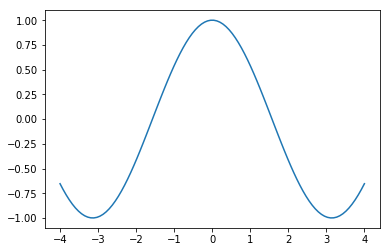

In [84]:
x = np.linspace(-4, 4, 100)
plt.plot(x, np.cos(x))
pass

In [85]:
optimize.minimize_scalar(np.cos)

     fun: -1.0
    nfev: 9
     nit: 8
 success: True
       x: 3.1415926536439596

#### Provide bounds for bounded search

In [86]:
optimize.minimize_scalar(np.cos, bounds=[-2,0], method='bounded')

     fun: -0.41614319477908951
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: -1.9999959949686341

#### Provide brackets for downhill search

In [87]:
optimize.minimize_scalar(np.cos, bracket=[-1,-2])

     fun: -0.99999999999999989
    nfev: 8
     nit: 7
 success: True
       x: -3.1415926702696373

### Vector-valued function

In [88]:
d = stats.multivariate_normal([2,3], np.eye(2))

In [89]:
x = np.linspace(-1,5,100)
y = np.linspace(0,6,100)
X, Y = np.meshgrid(x, y)
z = d.pdf(np.c_[X.ravel(), Y.ravel()]).reshape((100,100))

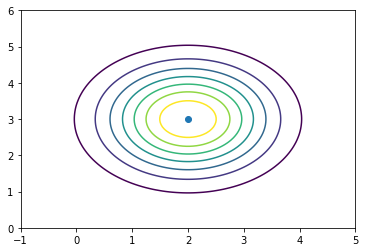

In [90]:
plt.contour(X, Y, z)
plt.scatter([[2]], [3])
pass

In [91]:
optimize.minimize(lambda x: -1*d.pdf(x), [0,0])

      fun: -0.15915494309093864
 hess_inv: array([[ 1212.355,  1817.032],
       [ 1817.032,  2726.548]])
      jac: array([  3.036e-07,   4.601e-07])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 2
     njev: 14
   status: 0
  success: True
        x: array([ 2.,  3.])

#### Constrained optimization

In [92]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

In [93]:
x0 = [0, 2.5]

Unconstrained optimization

In [94]:
ux = optimize.minimize(f, x0, constraints=None)
ux

      fun: -1.9999999999996365
 hess_inv: array([[ 0.998,  0.501],
       [ 0.501,  0.499]])
      jac: array([  1.252e-06,  -1.416e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([ 2.,  1.])

Constrained optimization

In [95]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

In [96]:
cx = optimize.minimize(f, x0, bounds=bnds, constraints=cons)
cx

     fun: 2.049915472092552
     jac: array([-3.487,  5.497])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 1.261,  2.005])

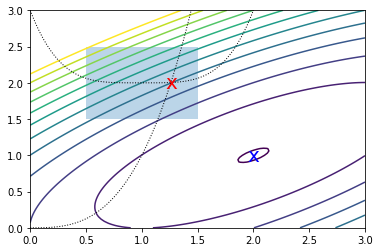

In [97]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1));
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3]);

### Curve-fitting

Curve fitting fits a scalar function to a series of data points. The `curve_fit` method provides a convenient interface for curve fitting.

In [98]:
def logistic4(x, a, b, c, d):
    """The four paramter logistic function is often used to fit dose-response relationships."""
    return ((a-d)/(1.0+((x/c)**b))) + d

Generate some noisy observations

In [99]:
nobs = 24
xdata = np.linspace(0.5, 3.5, nobs)
ptrue = [10, 3, 1.5, 12]
ydata = logistic4(xdata, *ptrue) + 0.5*np.random.random(nobs)

In [100]:
popt, pcov = optimize.curve_fit(logistic4, xdata, ydata)

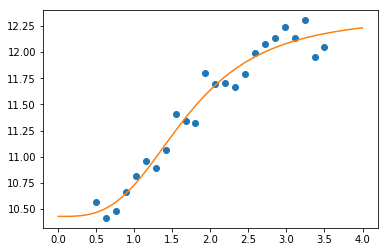

In [101]:
x = np.linspace(0, 4, 100)
y = logistic4(x, *popt)
plt.plot(xdata, ydata, 'o')
plt.plot(x, y)
pass

## Interpolation

Interpolation constructs new data points given a set of known data points. Often, its objective is to estimate intermediate data points. Interpolation is most commonly done by fitting piecewise polynomials with certain constraints to make the join points continuous or smooth.

This is different from what we did with curve-fitting optimization, where we desire to approximate a complicated **function** with a simpler one.

In [102]:
def f(x, t, a, b, c, d):
    """Lotka-Volterra model."""
    u, v = x
    return [a*u + b*u*v, c*v + d*u*v]

In [103]:
t = np.linspace(0, 22, 15)
a, b, c, d = 1, -1, -1, .5
x0 = [0.5,0.5]
y = integrate.odeint(f, x0, t, args=(a,b,c,d))

In [104]:
rabbits = y[:, 0]

#### Simple interpolation

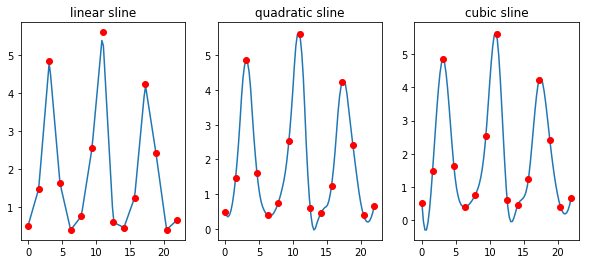

In [105]:
titles = ['linear', 'quadratic', 'cubic']
fig, axes = plt.subplots(1,3,figsize=(10, 4))

for i, ax in enumerate(axes, 1):
    ti = np.linspace(0, 22, 100)
    g = interpolate.interp1d(t, rabbits, kind=i)
    ax.plot(ti, g(ti))
    ax.plot(t, rabbits, 'ro')
    ax.set_title(titles[i-1] + ' sline')
pass

#### Using splines explicitly

The default smooths quite heavily. 

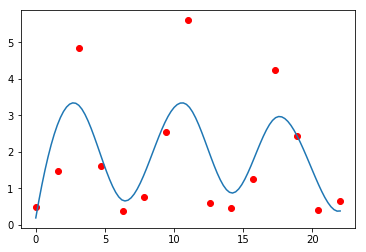

In [106]:
sp = interpolate.UnivariateSpline(t, rabbits)
plt.plot(t, rabbits, 'ro')
plt.plot(ti, sp(ti))
pass

We can control the amount of smoothing.

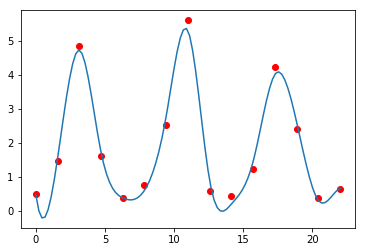

In [107]:
sp = interpolate.UnivariateSpline(t, rabbits)
sp.set_smoothing_factor(0.5)
plt.plot(t, rabbits, 'ro')
plt.plot(ti, sp(ti))
pass

Finding derivatives.

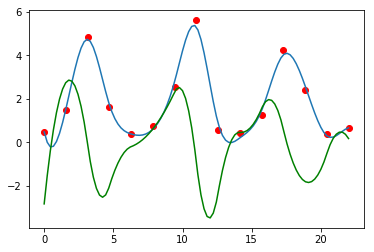

In [108]:
sp = interpolate.UnivariateSpline(t, rabbits)
sp.set_smoothing_factor(0.5)
sp1 = sp.derivative()
plt.plot(t, rabbits, 'ro')
plt.plot(ti, sp(ti))
plt.plot(ti, sp1(ti), 'g')
pass

Finding integrals (AUC). 

In [109]:
sp = interpolate.UnivariateSpline(t, rabbits)
sp.set_smoothing_factor(0.5)
sp2 = sp.antiderivative()
plt.plot(t, rabbits, 'ro')
plt.plot(ti, sp(ti))
plt.plot(ti, sp2(ti), 'g')
pass

## Exercises

**Exercise 1**

If twice the age of son is added to age of father, the sum is 56. But if twice the age of the father is added to the age of son, the sum is 82. Find the ages of father and son. Do this using `solve`.

$$
2x + y = 56 \\
x + 2y = 82
$$

In [110]:
A = np.array([[2,1], [1,2]])
y = np.array([56, 82])
linalg.solve(A, y)

array([ 10.,  36.])

**Exercise 2**

Using the `x` and `y` data given below, estimate the parameters `a`, `b` and `c` using `lstsq()` to fit a quadratic function.

Hints:

- The quadratic function is **linear** in the coefficients if you treat `x` and `x**2` as observed constants.
- The intercept can be found using a dummy variable which is always set to 1
- You will need to construct an $N \times 3$ matrix to pass to `lstsq()`.

For each $x_i$ and $y_i$, we have

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

and this is equivalent to

$$
y_i = \beta_0 x_i^0 + \beta_1 x_i^1 + \beta_2 x_i^2
$$

suggests re-writing in matrix notation

$$
y = X\beta
$$

where

$$
\pmatrix{
y_1 \\
y_2 \\ 
\cdots 
\\ y_m} = 
\pmatrix{
1 & x_1 & x_1^2 \\
1 & x_2 & x_2^2 \\
&\cdots \\
1 & x_m & x_m^2}
\pmatrix{
\beta_0 \\
\beta_1 \\
\beta_2
}
$$

In [111]:
n = 1000
a, b, c = 1, 2, 3
x = np.arange(n)
y = a + b*x + c*x**2 + np.random.normal(0, 1, n)

In [112]:
X = np.c_[np.ones(n), x, x**2]
linalg.lstsq(X, y)[0]

array([ 1.003,  2.   ,  3.   ])

**Exercise 3**

Estimate the probability of being between 0 and 3 for the PDF given below by integration.

In [113]:
from mystery import pdf

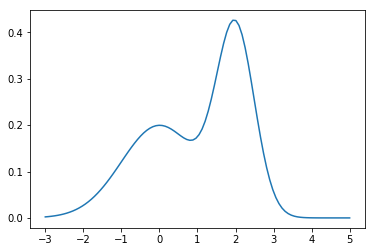

In [114]:
x = np.linspace(-3, 5, 100)
plt.plot(x, pdf(x))
pass

In [115]:
integrate.quad(pdf, 0, 3)

(0.7379341493891789, 8.1927148211271e-15)

**Exercise 4**

Plot the amount of a radioactive substance over 30 days, if we start with 100 units and its half-life is 7 days.

In [116]:
def decay(x, t, mu):
    """dy/dt"""
    return -mu*x

In [117]:
x0 = 100
mu = np.log(2)/7
t = np.linspace(0, 30, 100)
y = integrate.odeint(decay, x0, t, args=(mu,))
plt.plot(t, y)
pass

**Exercise 5**

You have some noisy measurements of the amount of radioactive material over time. 

- Estimate the decay constant using the closed form solution for exponential decay
- Plot the observed data points in red
- Plot a fitted a decay curve in blue
- Plot a smooth interpolated curve using cubic splines in green

Recall the closed form solution

$$
x_t = x_0 e^{-\mu t}
$$

In [118]:
def f(t, x0, mu):
    return -mu*x0

In [119]:
t = np.array([1, 4, 7, 10, 14, 21])
y = np.array([ 100. , 74.082,  54.881, 40.657, 27.253, 13.534])

In [120]:
def orbit(t, x0, mu):
    """Closed form solution."""
    return x0 * np.exp(-mu * t)

In [121]:
popt, pcov = optimize.curve_fit(orbit, t, y)
x0, mu = popt

In [122]:
mu

0.099999864435514327

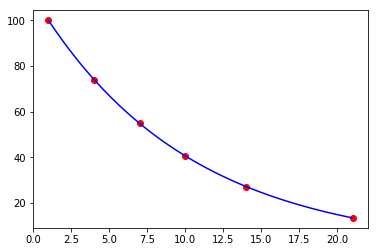

In [123]:
plt.scatter(t, y, c='red')
tp = np.linspace(t[0], t[-1], 100)
yp = orbit(tp, x0, mu)
plt.plot(tp, yp, c='blue')
pass

In [124]:
plt.scatter(t, y, c='red')
f = interpolate.interp1d(t, y, kind='cubic')
plt.plot(tp, f(tp), c='green')
pass